# Regularyzacja w modelu regresji - wstęp

In [79]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from scipy import stats
from patsy import dmatrices

from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# Zadanie 1a

Wygeneruj $n$ par punktów (x, y) takich, że
$$
y = x - 2x^2 + 0.5x^3 + e,
$$
gdzie $e\sim\mathcal{N}(\mu, \sigma)$. 
A następnie dopasuj model

a) regresji liniowej: $y=\beta_0 + \beta_1\cdot x$

b) regresji wielomianowej stopnia 2: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2$,

c) regresji wielomianowej stopnia 3: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2 + \beta_3\cdot x^3$,

d) regresji wielomianowej stopnia 20: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2 + \ldots + \beta_{20}\cdot x^{20}$.

Zaznacz na wykresie rozproszenia punktów $(x, y)$ funkcję regresji.

**Wskazówka**: `ols('y ~ x + I(x**k)', data_frame)` z `statsmodels.formula.api` lub `PolynomialFeatures` z `sklearn.preprocessing`

In [80]:
#generujemy dane
n = 50
x = stats.uniform.rvs(size=n, loc=-3, scale=6)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + stats.norm.rvs(size=n, loc=2, scale=2)

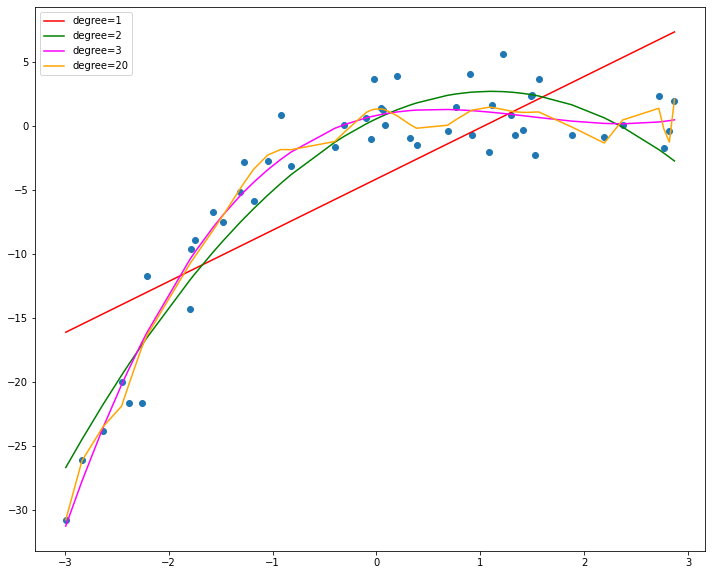

In [81]:
#rysujemy dopasowanie dla modeli wielomianowych o rzędzie wielomianu równym: 1, 2, 3 i 20
import operator

colors = ['red', 'green', 'magenta', 'orange']
degrees = [1, 2, 3, 20]

plt.scatter(x, y)
sort_axis = operator.itemgetter(0)

for i, deg in enumerate(degrees):
    if deg == 1:
        X = add_constant(x, prepend=True, has_constant='skip')
    else:
        polynomial_features = PolynomialFeatures(degree=deg)
        X = polynomial_features.fit_transform(x.reshape(-1, 1))
    model = OLS(endog=y, exog=X).fit()
    
    sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
    x_range, y_poly_pred = zip(*sorted_zip)
    plt.plot(x_range, y_poly_pred, color=colors[i], label="degree={}".format(deg))

plt.legend()

# Zadanie 1b

Dla wygenerowanej pary punktów dopasuj model regresji:

a) wielomianowej stopnia 20 z regularyzacją grzbietową (Ridge) z parametrem $\alpha = 0.1$,

b) wielomianowej stopnia 20 z regularyzacją Lasso z parametrem $\alpha = 0.1$.

Powtórz podpunkt a) i b) dla różnych wartości parametru $\alpha$, np. $\alpha \in \{0.001, 0.005, 0.01, 0.5, 1, 5\}$.

In [82]:
# Rigde - powinno wygładzać wielomian (zwalczamy problem przeuczenia modelu)
# Sposob I
X = x.reshape(-1, 1)
polynomial_features_20 = PolynomialFeatures(degree=20,include_bias = False)
X20 = polynomial_features_20.fit_transform(X)

In [83]:
X20.shape

(50, 20)

In [84]:
X20

array([[-2.26099707e+00,  5.11210776e+00, -1.15584607e+01,
         2.61336458e+01, -5.90880966e+01,  1.33598013e+02,
        -3.02064717e+02,  6.82967441e+02, -1.54418739e+03,
         3.49140316e+03, -7.89405232e+03,  1.78484292e+04,
        -4.03552461e+04,  9.12430933e+04, -2.06300367e+05,
         4.66444526e+05, -1.05462971e+06,  2.38451468e+06,
        -5.39138071e+06,  1.21898960e+07],
       [ 3.19342950e-01,  1.01979920e-01,  3.25665683e-02,
         1.03999040e-02,  3.32113602e-03,  1.06058137e-03,
         3.38689184e-04,  1.08158003e-04,  3.45394958e-05,
         1.10299445e-05,  3.52233500e-06,  1.12483285e-06,
         3.59207440e-07,  1.14710364e-07,  3.66319459e-08,
         1.16981536e-08,  3.73572289e-09,  1.19297677e-09,
         3.80968720e-10,  1.21659675e-10],
       [-2.38544619e+00,  5.69035353e+00, -1.35740322e+01,
         3.23801233e+01, -7.72410418e+01,  1.84254349e+02,
        -4.39528835e+02,  1.04847238e+03, -2.50107446e+03,
         5.96617853e+03, -1.4

In [85]:
X20_scale = StandardScaler().fit_transform(X20) # (x - mean) / std (aby móc użyć Ridge lub Lasso najpierw trzeba zeskalować kolumny X)
X20_scale

array([[-1.40406579e+00,  9.15263624e-01, -1.18481709e+00,
         5.47169257e-01, -8.20664370e-01,  2.27389265e-01,
        -5.37061168e-01,  5.41183216e-03, -3.39807760e-01,
        -1.35066456e-01, -2.07513011e-01, -2.18107361e-01,
        -1.19673498e-01, -2.63479210e-01, -6.09662150e-02,
        -2.85137240e-01, -2.09300879e-02, -2.92329592e-01,
         7.24854866e-03, -2.90989420e-01],
       [ 1.71439534e-01, -9.73147039e-01,  1.34170362e-02,
        -6.54820820e-01,  6.27911405e-03, -5.31818822e-01,
         1.16222386e-03, -4.68450831e-01,  4.20528954e-04,
        -4.27063435e-01,  3.62526860e-03, -3.96069966e-01,
         9.61225778e-03, -3.70932063e-01,  1.73653728e-02,
        -3.49491822e-01,  2.61131143e-02, -3.30598056e-01,
         3.52893194e-02, -3.13603525e-01],
       [-1.48005200e+00,  1.13321524e+00, -1.39317882e+00,
         8.34583923e-01, -1.07470227e+00,  5.15260348e-01,
        -7.81996496e-01,  2.59009827e-01, -5.50637124e-01,
         7.19067591e-02, -3.7

In [86]:
ridge01 = Ridge(alpha=0.1).fit(X=X20_scale, y=y) #definiujemy Ridge z zadanym parametrem i od razu dopasowujemy do zeskalowanych danych
ridge01

Ridge(alpha=0.1)

In [87]:
lm =  LinearRegression().fit(X20,y)

In [92]:
print(ridge01.coef_) # [b1, b2, ..., b20] w ridge (bez wyrazu wolnego)
print(lm.coef_) # [b1, b2, ..., b20] w zwykłym lm (bez wyrazu wolnego)


[ 2.47059463 -3.60593724  4.23929317 -2.69706334  1.10272513 -0.49475575
 -0.20595533  0.77054071 -0.69868534  1.11587614 -0.82923333  0.95705424
 -0.68139711  0.56767516 -0.27023448  0.08943819  0.37341288 -0.40925255
  1.19820894 -0.89679784]
[ 8.33953854e-01 -2.05144329e+01  3.15521481e+00  5.88774985e+01
 -5.46276696e+00 -7.44038198e+01  5.00812751e+00  5.04303485e+01
 -2.31625277e+00 -2.04899067e+01  6.01675328e-01  5.22555847e+00
 -9.42914322e-02 -8.43212880e-01  9.23477688e-03  8.35765459e-02
 -5.44478295e-04 -4.64282058e-03  1.50607401e-05  1.10632166e-04]


In [93]:
print(ridge01.intercept_) 
print(lm.intercept_) 
# wyrazy wolne poszczególnych metod

-4.007143251179378
1.3087348913506043


In [95]:
ridge01_params = [ridge01.intercept_] + list(ridge01.coef_[1:])
ridge01_params # wyraz wolny i wspolczynniki regresji

[-4.007143251179378,
 -3.605937239200008,
 4.2392931661413265,
 -2.6970633415329206,
 1.102725129452105,
 -0.49475574710388903,
 -0.20595532655500373,
 0.7705407070461177,
 -0.6986853401830605,
 1.1158761384700957,
 -0.8292333328100789,
 0.9570542445665364,
 -0.6813971120108068,
 0.5676751592190206,
 -0.27023447966776637,
 0.08943818602147523,
 0.3734128822302173,
 -0.40925254921237175,
 1.1982089439102255,
 -0.8967978419279728]

In [96]:
print("Współczynniki regresji z regularyzacja Ridge: {}".format(ridge01_params))
ridge01_r2 = ridge01.score(X20_scale, y)
print("R2: {}".format(ridge01_r2))

Współczynniki regresji z regularyzacja Ridge: [-4.007143251179378, -3.605937239200008, 4.2392931661413265, -2.6970633415329206, 1.102725129452105, -0.49475574710388903, -0.20595532655500373, 0.7705407070461177, -0.6986853401830605, 1.1158761384700957, -0.8292333328100789, 0.9570542445665364, -0.6813971120108068, 0.5676751592190206, -0.27023447966776637, 0.08943818602147523, 0.3734128822302173, -0.40925254921237175, 1.1982089439102255, -0.8967978419279728]
R2: 0.9435877751668144


In [98]:
## Sposob 2 - pipeline

ridge01_pipeline = make_pipeline(
    PolynomialFeatures(degree=20,include_bias = False),
    StandardScaler(),
    Ridge(alpha=0.1)
)
ridge01_pipeline = ridge01_pipeline.fit(X=X, y=y)

In [99]:
ridge01_pipeline['ridge']

Ridge(alpha=0.1)

In [101]:
ridge01_params = [ridge01_pipeline['ridge'].intercept_] + list(ridge01_pipeline['ridge'].coef_[1:])
print("Współczynniki regresji z regularyzacja Ridge: {}".format(ridge01_params)) #współczynniki
ridge01_r2 = ridge01_pipeline['ridge'].score(X20_scale, y)
print("R2: {}".format(ridge01_r2)) #R^2

Współczynniki regresji z regularyzacja Ridge: [-4.007143251179378, -3.605937239200008, 4.2392931661413265, -2.6970633415329206, 1.102725129452105, -0.49475574710388903, -0.20595532655500373, 0.7705407070461177, -0.6986853401830605, 1.1158761384700957, -0.8292333328100789, 0.9570542445665364, -0.6813971120108068, 0.5676751592190206, -0.27023447966776637, 0.08943818602147523, 0.3734128822302173, -0.40925254921237175, 1.1982089439102255, -0.8967978419279728]
R2: 0.9435877751668144


In [102]:
ridge01.predict(X20_scale) #wartości dopasowane

array([-1.78231797e+01,  1.01393057e+00, -1.99186393e+01,  5.75354836e-01,
        7.71768496e-01, -4.02356731e+00,  1.10035057e+00, -1.69784973e+01,
       -5.09266880e+00,  8.02834197e-01, -3.06227897e+01,  1.17354714e+00,
       -6.61089778e+00, -2.65511211e+01, -2.10375677e+01,  1.15947061e+00,
       -3.08007796e+00,  8.20107029e-01, -9.79798438e+00, -1.80740004e+00,
        4.86086371e-02,  9.79506616e-01, -1.03441508e+01, -4.79152668e+00,
       -2.36855544e+01,  1.06004966e+00,  7.74534348e-01, -1.98740791e-01,
       -1.04388469e+01,  9.69595648e-01,  9.04852785e-01,  2.37889411e-01,
        5.66831734e-01, -7.69562143e+00,  3.39909508e-01,  9.49530027e-01,
        4.96975649e-01, -2.32910772e+00, -3.27938568e-01,  1.03310858e+00,
        1.15596512e+00,  7.18101872e-01,  7.39493861e-01, -1.20831490e-01,
        8.83378109e-01,  7.52969807e-01,  1.27155866e-02,  1.16882543e+00,
        6.19640173e-01,  1.08970147e+00])

In [104]:
ridge01_fittedvalues = ridge01_pipeline.predict(X) #wartości dopasowane obliczone za pomocą pipeline'a
ridge01_fittedvalues
#to samo co wcześniej - metody są równoważne

array([-1.78231797e+01,  1.01393057e+00, -1.99186393e+01,  5.75354836e-01,
        7.71768496e-01, -4.02356731e+00,  1.10035057e+00, -1.69784973e+01,
       -5.09266880e+00,  8.02834197e-01, -3.06227897e+01,  1.17354714e+00,
       -6.61089778e+00, -2.65511211e+01, -2.10375677e+01,  1.15947061e+00,
       -3.08007796e+00,  8.20107029e-01, -9.79798438e+00, -1.80740004e+00,
        4.86086371e-02,  9.79506616e-01, -1.03441508e+01, -4.79152668e+00,
       -2.36855544e+01,  1.06004966e+00,  7.74534348e-01, -1.98740791e-01,
       -1.04388469e+01,  9.69595648e-01,  9.04852785e-01,  2.37889411e-01,
        5.66831734e-01, -7.69562143e+00,  3.39909508e-01,  9.49530027e-01,
        4.96975649e-01, -2.32910772e+00, -3.27938568e-01,  1.03310858e+00,
        1.15596512e+00,  7.18101872e-01,  7.39493861e-01, -1.20831490e-01,
        8.83378109e-01,  7.52969807e-01,  1.27155866e-02,  1.16882543e+00,
        6.19640173e-01,  1.08970147e+00])

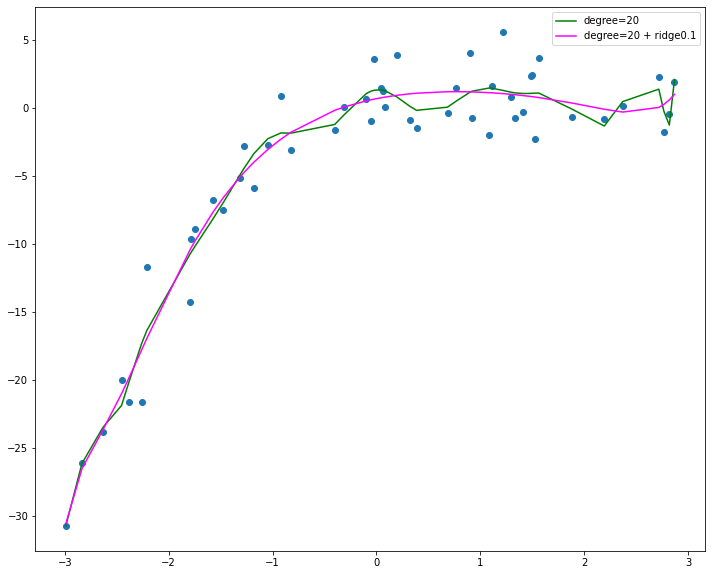

In [105]:
#wykres dopasowania dla regresji wielomianowej bez kary ridge, a także z tą karą
plt.scatter(x, y)
sort_axis = operator.itemgetter(0)


polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

sorted_zip = sorted(zip(x, ridge01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[2], label="degree={} + ridge0.1".format(deg))


plt.legend()
#widzimy, że ridge się nie przeuczyło

In [106]:
#teraz pipeline dla lasso
lasso01_pipeline = make_pipeline(
    PolynomialFeatures(degree=20,include_bias = False),
    StandardScaler(),
    Lasso(alpha=0.1, max_iter=10e5)
)
lasso01_pipeline.fit(X, y)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=20, include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.1, max_iter=1000000.0))])

In [107]:
lasso01_params = [lasso01_pipeline['lasso'].intercept_] + list(lasso01_pipeline['lasso'].coef_[1:])
print("Współczynniki regresji z regularyzacja Lasso: {}".format(lasso01_params))
lasso01_r2 = lasso01_pipeline.score(X, y)
print("R2: {}".format(lasso01_r2))

Współczynniki regresji z regularyzacja Lasso: [-4.007143251179377, -4.677573525384297, 3.8325332280027165, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0]
R2: 0.940775310539484


In [109]:
lasso01_fittedvalues = lasso01_pipeline.predict(X) #wartości dopasowane

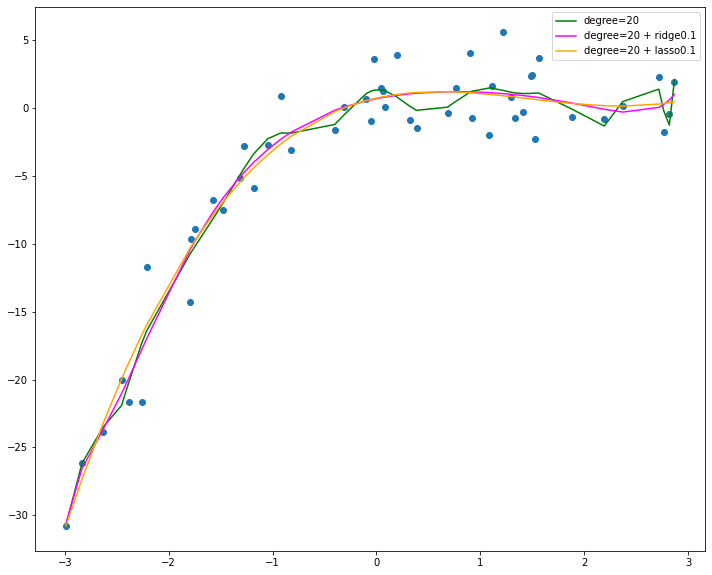

In [110]:
#wykres dopasowania dla regresji wielomianowej bez kary, z karą ridge i z karą lasso
plt.scatter(x, y)
sort_axis = operator.itemgetter(0)


polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

sorted_zip = sorted(zip(x, ridge01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[2], label="degree={} + ridge0.1".format(deg))

sorted_zip = sorted(zip(x, lasso01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[3], label="degree={} + lasso0.1".format(deg))

plt.legend()

#widzimy, że i ridge i lasso się nie przeuczyło

# Zadanie 2

Narysuj wykres funkcji 
$$y = cos(x) + \epsilon$$
dla $x \in [\frac{\pi}{2}, \frac{3}{2}\pi]$ oraz $\epsilon \in N(0, 0.15)$.

Dopasuj model regresji:
- liniowej
- wielomianej stopnia 2, 10 i 20,
- wielomianej stopnia 20 z regularyzacja Ridge z parametrem $\alpha\in\{0.001, 0.01, 0.1, 1, 2\}$.
- wielomianej stopnia 20 z regularyzacją Lasso z parametrem $\alpha\in\{0.001, 0.01, 0.1, 1, 2\}$.

**Wskazówka**: Napisz funkcję, która dla dowolnego zbioru dopasuje odpowiedni model.

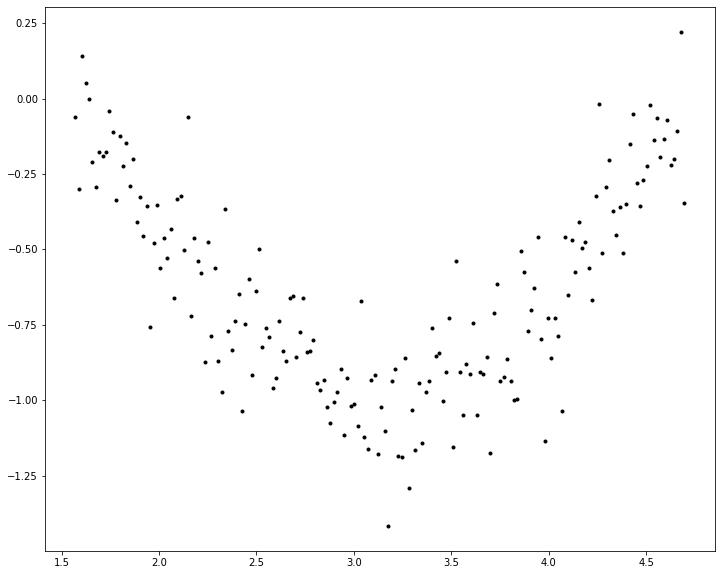

In [115]:
#generacja danych
x = np.array([i*np.pi/180 for i in range(90,270,1)])
X = pd.DataFrame(x)
y = np.cos(x)+np.random.normal(0,0.15,len(x))
plt.plot(x,y,'.',color = 'black')

In [116]:
#funkcja dopasowywująca modele, które nas interesują
def fit_model(X,y,model,power):
  new_model = make_pipeline(
      PolynomialFeatures(degree = power,include_bias = False),
      StandardScaler(),
      model
  )
  new_model.fit(X,y)
  return(new_model.predict(X))

In [117]:
#dopasowujemy modele
models = {}
models['linear_regression'] = {'power': 1, 'model': LinearRegression()}
models['polynomial_regression2'] = {'power': 2, 'model': LinearRegression()}
models['polynomial_regression10'] = {'power': 10, 'model': LinearRegression()}
models['polynomial_regression20'] = {'power': 20, 'model': LinearRegression()}
models['ridge_regression_0.1'] = {'power': 20, 'model': Ridge(alpha = 0.1)}
models['lasso_regression_0.1'] = {'power': 20, 'model': Lasso(alpha = 0.1)}

In [118]:
#definiujemy miarę RSS (czyli właściwie MSE razy liczba obserwacji)
def rss_fun(y,y_pred):
  return(sum((y-y_pred)**2))

In [119]:
#liczymy RSS dla każdego modelu na danych na których uczyliśmy model
y_pred_dict = {}
rss = {}
for key,values in zip(models,models.values()):
  y_pred = fit_model(X,y,values['model'],values['power'])
  y_pred_dict[key] = y_pred
  rss[key] = rss_fun(y_pred,y)

In [120]:
pd.DataFrame(list(rss.items()),columns = ['Model','RSS'])
#nie dziwi, że RSS najmniejsze dla regresji wielomianu 20 stopnia, bo ten model najlepiej dopasuje się do danych na których był uczony, 
#ale na innym zbiorze danych już pewnie taki nie będzie (overfitting) 

,Model,RSS
0,linear_regression,21.138022
1,polynomial_regression2,4.629805
2,polynomial_regression10,4.305702
3,polynomial_regression20,4.132432
4,ridge_regression_0.1,4.442151
5,lasso_regression_0.1,17.732358


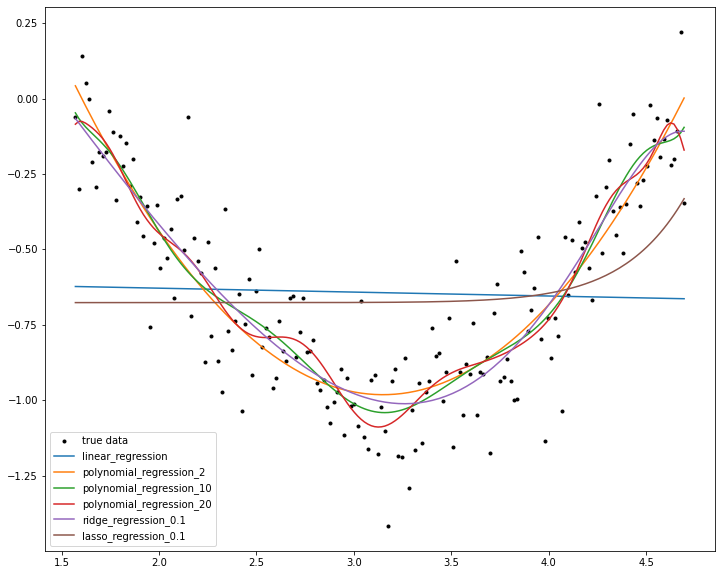

In [121]:
rcParams['figure.figsize'] = 12, 10

labels = ['true data'] + ['linear_regression', 'polynomial_regression_2', 
                          'polynomial_regression_10', 'polynomial_regression_20', 
                          'ridge_regression_0.1', 'lasso_regression_0.1']

plt.plot(x, y, '.', color = 'black', label="data")
for y_pred in y_pred_dict.values():
    plt.plot(x, y_pred)
plt.legend(labels)

#polynomial 20 przeuczony, ridge z alpha = 0.1 ok, lasso z alpha = 0.1 niedouczony